In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
import keras
import tensorflow as tf
import numpy as np

Using TensorFlow backend.


In [2]:
def augmentImages(images, multFactor, nRows=110, nCols=110, channels=1):
    """ Applies series of Keras image preprocessing techniques to increase size of training dataset
        Input: An array of images [numImages, nRows, nCols, channels], 
           multiplicative factor for the image set, 
           number of rows in image,
           number of columns in image,
           number of image channels,
        Output: An array of images [numImages*multFactor, nRows, nCols, channels]
    """
    gen = ImageDataGenerator()        
    newImages = []    
    for _ in range(multFactor):
        for image in images:
            transformedImage = gen.apply_transform(image, {'theta': np.random.choice(range(270)),
                                                           'brightness': np.random.uniform(low=0.001, high=0.99)})
            newImages.append(transformedImage)
    newImages = np.array(newImages)    
    return newImages

In [3]:
trainImagesFile = 'train_images.csv'
trainLabelsFile = 'train_labels.csv'
testImagesFile = 'test_images.csv'
testLabelsFile = 'test_labels.csv'

In [4]:
# load images and toss out the row and column headers, load the labels
dfTrainImages = pd.read_csv(trainImagesFile, index_col=False, header=None)
dfTrainLabels = pd.read_csv(trainLabelsFile)
dfTestImages = pd.read_csv(testImagesFile, index_col=False, header=None)
dfTestLabels = pd.read_csv(testLabelsFile)

In [5]:
# Convert all data frames to numpy arrays
dfTrainImages = dfTrainImages.values
dfTrainLabels = dfTrainLabels.values
dfTestImages = dfTestImages.values
dfTestLabels = dfTestLabels.values

In [6]:
# Keras expects 4D array for model
dfTrainImages = dfTrainImages.reshape(-1, 110, 110, 1)
dfTestImages = dfTestImages.reshape(-1, 110, 110, 1)

In [7]:
# replace the NaN with 0s, makes denoting the classes easier
dfTrainLabels = np.nan_to_num(dfTrainLabels)
dfTestLabels = np.nan_to_num(dfTestLabels)

In [41]:
# get the labels, 1, 2, 3, 4. Please see the venus data set documentation at
# https://www.kaggle.com/fmena14/volcanoesvenus
trainLabels = dfTrainLabels[:,1]
testLabels = dfTestLabels[:,1]

zeros = np.where(trainLabels == 0)[0]
ones = np.where(trainLabels == 1)[0]
twos = np.where(trainLabels == 2)[0]
threes = np.where(trainLabels == 3)[0]
fours = np.where(trainLabels == 4)[0]

# check training distributions - yup it's horribly skewed
zeros.size/7000, ones.size/7000, twos.size/7000, threes.size/7000, fours.size/7000
#zeros.size, ones.size, twos.size, threes.size, fours.size

(0.8571428571428571,
 0.015,
 0.026714285714285715,
 0.049428571428571426,
 0.05171428571428571)

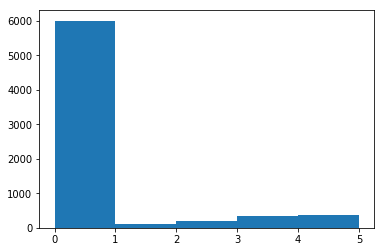

In [9]:
# visualize distribution of classes
plt.hist(dfTrainLabels[:,1], bins=[0,1,2,3,4,5])
plt.show()

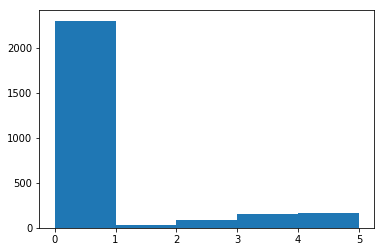

In [10]:
plt.hist(dfTestLabels[:,1], bins=[0,1,2,3,4,5])
plt.show()

In [40]:
total = len(testLabels)
testZeros = np.where(testLabels == 0)[0]
testOnes = np.where(testLabels == 1)[0]
testTwos = np.where(testLabels == 2)[0]
testThrees = np.where(testLabels == 3)[0]
testFours = np.where(testLabels == 4)[0]

# check test distributions - yup it's horribly skewed
testZeros.size/total, testOnes.size/total, testTwos.size/total, testThrees.size/total, testFours.size/total
#testZeros.size, testOnes.size, testTwos.size, testThrees.size, testFours.size

(0.8412582297000731,
 0.012801755669348939,
 0.03218727139722019,
 0.05413313825896123,
 0.05961960497439649)

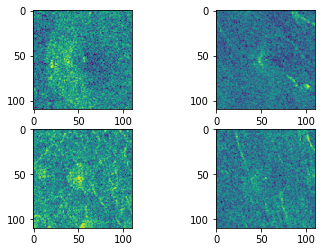

In [11]:
# let's check out some random volcanoes
for i in range(0,4):
    img = np.random.choice(len(ones))
    plt.subplot(221 + (i))
    plt.imshow(dfTrainImages[ones[img]].reshape(110,110))
plt.show()

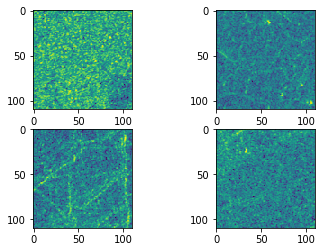

In [12]:
# check out some random NOT volcanoes
for i in range(0,4):
    img = np.random.choice(len(zeros))
    plt.subplot(221 + (i))
    plt.imshow(dfTrainImages[zeros[img]].reshape(110,110))
plt.show()

In [42]:
trainLabels = keras.utils.to_categorical(trainLabels, 5)
testLabels = keras.utils.to_categorical(testLabels, 5)

In [14]:
model = Sequential()
model.add(Conv2D(16, (4,4), activation='relu', input_shape=(110, 110,1)))
model.add(Conv2D(32, (4,4), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (2,2), activation='relu'))
model.add(Conv2D(128, (2,2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(5, activation='softmax'))

In [15]:
model.compile(optimizer=keras.optimizers.SGD(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
# Next we need to augment the images, so split them out into types. This is to get approximately equal numbers 
# of each class
noVolcanoes = dfTrainImages[zeros]
volcanoes = dfTrainImages[ones]
volcanoes2 = dfTrainImages[twos]
volcanoes3 = dfTrainImages[threes]
volcanoes4 = dfTrainImages[fours]

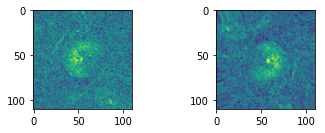

In [17]:
newImage = augmentImages([volcanoes[0]], multFactor=1)
plt.subplot(221)
plt.imshow(volcanoes[0].reshape(110,110))
plt.subplot(222)
plt.imshow(newImage.reshape(110,110))
plt.show()

In [18]:
augmentedVolcanoes =  augmentImages(volcanoes,  multFactor=50)
augmentedVolcanoes2 = augmentImages(volcanoes2, multFactor=35)
augmentedVolcanoes3 = augmentImages(volcanoes3, multFactor=15)
augmentedVolcanoes4 = augmentImages(volcanoes4, multFactor=15)

In [19]:
# now we have to reassemble the dataset and construct the new labels
x_train = np.vstack([noVolcanoes, augmentedVolcanoes, augmentedVolcanoes2, augmentedVolcanoes3, augmentedVolcanoes4])

noVolcanoesLabels = np.zeros(noVolcanoes.shape[0])
augmentedVolcanoesLabels = np.ones(augmentedVolcanoes.shape[0])
augmentedVolcanoes2Labels = 2*np.ones(augmentedVolcanoes2.shape[0])
augmentedVolcanoes3Labels = 3*np.ones(augmentedVolcanoes3.shape[0])
augmentedVolcanoes4Labels = 4*np.ones(augmentedVolcanoes4.shape[0])

y_train = np.hstack([noVolcanoesLabels, augmentedVolcanoesLabels, augmentedVolcanoes2Labels, 
                     augmentedVolcanoes3Labels, augmentedVolcanoes4Labels])

In [20]:
x_train, y_train = shuffle(x_train, y_train)

In [21]:
y_train = keras.utils.to_categorical(y_train, 5)

In [22]:
model.fit(x_train, y_train, batch_size=64, verbose=1, epochs=50)

Epoch 1/50
28415/28415 [==============================] - 20s 695us/step - loss: 1.7937 - acc: 0.2741
Epoch 2/50
28415/28415 [==============================] - 18s 625us/step - loss: 1.3153 - acc: 0.4353
Epoch 3/50
28415/28415 [==============================] - 18s 626us/step - loss: 1.2545 - acc: 0.4631
Epoch 4/50
28415/28415 [==============================] - ETA: 0s - loss: 1.1163 - acc: 0.507 - 18s 627us/step - loss: 1.1163 - acc: 0.5077
Epoch 5/50
28415/28415 [==============================] - 18s 628us/step - loss: 1.0662 - acc: 0.5262
Epoch 6/50
28415/28415 [==============================] - 18s 627us/step - loss: 1.0426 - acc: 0.5425
Epoch 7/50
28415/28415 [==============================] - 18s 628us/step - loss: 1.0974 - acc: 0.5387
Epoch 8/50
28415/28415 [==============================] - 18s 627us/step - loss: 1.0360 - acc: 0.5575
Epoch 9/50
28415/28415 [==============================] - 18s 628us/step - loss: 0.9903 - acc: 0.5773
Epoch 10/50
28415/28415 [===================

In [23]:
score = model.evaluate(dfTestImages, testLabels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy', score[1])

Test loss: 1.2049557184466675
Test accuracy 0.8730797365187901


In [24]:
predictions = model.predict(dfTestImages)
classes = np.array([np.argmax(row) for row in predictions], dtype=np.float16)

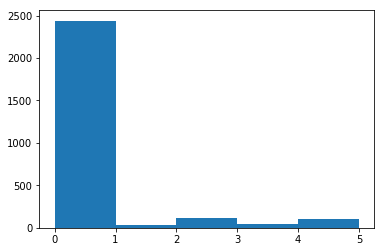

In [25]:
plt.hist(classes, bins=[0,1,2,3,4,5])
plt.show()

In [26]:
possibleVolcanoes = np.where(classes == 1)[0]

In [30]:
print(dfTestLabels[:20,1])
print(classes[:20])

[0. 0. 1. 0. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [28]:
model.fit(x_train, y_train, batch_size=64, verbose=1, epochs=15)

Epoch 1/15
28415/28415 [==============================] - 17s 612us/step - loss: 0.1286 - acc: 0.9649
Epoch 2/15
28415/28415 [==============================] - 17s 613us/step - loss: 0.1087 - acc: 0.9711
Epoch 3/15
28415/28415 [==============================] - 18s 621us/step - loss: 0.1075 - acc: 0.9724
Epoch 4/15
28415/28415 [==============================] - 18s 618us/step - loss: 0.2753 - acc: 0.9302
Epoch 5/15
28415/28415 [==============================] - 17s 615us/step - loss: 0.4061 - acc: 0.8657
Epoch 6/15
28415/28415 [==============================] - 18s 620us/step - loss: 0.1038 - acc: 0.9740
Epoch 7/15
28415/28415 [==============================] - 17s 616us/step - loss: 0.0917 - acc: 0.9755
Epoch 8/15
28415/28415 [==============================] - 18s 621us/step - loss: 0.1090 - acc: 0.9727
Epoch 9/15
28415/28415 [==============================] - 18s 618us/step - loss: 0.0812 - acc: 0.9792
Epoch 10/15
28415/28415 [==============================] - 17s 613us/step - loss: 

In [29]:
score = model.evaluate(dfTestImages, testLabels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy', score[1])

Test loss: 1.349617116157413
Test accuracy 0.8749085588880761


In [31]:
model.fit(x_train, y_train, batch_size=64, verbose=1, epochs=25)

Epoch 1/15
28415/28415 [==============================] - 18s 620us/step - loss: 0.0834 - acc: 0.9799
Epoch 2/15
28415/28415 [==============================] - 17s 605us/step - loss: 0.0822 - acc: 0.9804
Epoch 3/15
28415/28415 [==============================] - 17s 607us/step - loss: 0.0666 - acc: 0.9833
Epoch 4/15
28415/28415 [==============================] - 17s 607us/step - loss: 0.0624 - acc: 0.9850
Epoch 5/15
28415/28415 [==============================] - 17s 607us/step - loss: 0.0675 - acc: 0.9832
Epoch 6/15
28415/28415 [==============================] - 17s 607us/step - loss: 0.0625 - acc: 0.9846
Epoch 7/15
28415/28415 [==============================] - 17s 606us/step - loss: 0.0579 - acc: 0.9863
Epoch 8/15
28415/28415 [==============================] - 17s 613us/step - loss: 0.0557 - acc: 0.9868
Epoch 9/15
28415/28415 [==============================] - 17s 606us/step - loss: 0.2003 - acc: 0.9456
Epoch 10/15
28415/28415 [==============================] - 17s 610us/step - loss: 

In [32]:
score = model.evaluate(dfTestImages, testLabels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy', score[1])

Test loss: 1.3577875733590496
Test accuracy 0.8782004387865296


In [ ]:
# 84.1% just by guessing 0